# Installing and importing the necessary libraries

In [1]:
!pip install contractions

In [2]:
!pip install gensim

In [3]:
import pandas as pd
import numpy as np
import contractions
import nltk
from nltk.corpus import stopwords
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from gensim.models import FastText
#from contractions import contraction_map
from contractions import contractions_dict
import string,re
from nltk.stem import WordNetLemmatizer

<ipython-input-3-17e88a8692b8>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [4]:
from contractions import contractions_dict

## Importing the repos

In [5]:
df_train = pd.read_csv("C:\\Users\\Manju Krishna\\Desktop\\train.txt", delimiter=';', header=None, names=['sentence','label'])
df_test = pd.read_csv("C:\\Users\\Manju Krishna\\Desktop\\test.txt", delimiter=';', header=None, names=['sentence','label'])


In [6]:
import csv

with open('C:\\Users\\Manju Krishna\\Desktop\\train.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(";") for line in stripped if line)
    with open('C:\\Users\\Manju Krishna\\Desktop\\train.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('text', 'sentiment'))
        writer.writerows(lines)

In [7]:
df_train=pd.read_csv("C:\\Users\\Manju Krishna\\Desktop\\train_.csv")

In [9]:
df_train.sentiment.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: sentiment, dtype: int64

In [10]:
import csv

with open('C:\\Users\\Manju Krishna\\Desktop\\test.txt', 'r') as in_file:
    stripped = (line.strip() for line in in_file)
    lines = (line.split(";") for line in stripped if line)
    with open('C:\\Users\\Manju Krishna\\Desktop\\test.csv', 'w') as out_file:
        writer = csv.writer(out_file)
        writer.writerow(('text', 'sentiment'))
        writer.writerows(lines)

In [11]:
df_test=pd.read_csv("C:\\Users\\Manju Krishna\\Desktop\\test.csv")

In [14]:
df_test.sentiment.value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: sentiment, dtype: int64

In [15]:
data = pd.concat([df_train,df_test])

In [16]:
data.shape

(18000, 2)

In [17]:
df_train

,text,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [18]:
df_test

,text,sentiment
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


Data pre-processing

In [19]:
df_pos = pd.read_csv("C:\\Users\\Manju Krishna\\Desktop\\positive-words.txt", sep = '\t')[37:].reset_index().drop(columns=['index'])
df_neg = pd.read_csv("C:\\Users\\Manju Krishna\\Desktop\\negative-words.txt", sep = '\t',encoding="ISO-8859-1")[36:].reset_index().drop(columns=['index'])

In [20]:
df_pos = df_pos.rename(columns={df_pos.columns[0]:"words"})
df_neg = df_neg.rename(columns={df_neg.columns[0]:"words"})

In [21]:
def expand_text(text):
    text = text.lower()
    text = text.replace("`","'")
    
    #Expand Contractions
    contraction_dict = contractions_dict
    contraction_keys = list(contraction_dict.keys())
    
    for word in text.split():
        if word in contraction_keys:
            text = text.replace(word, contraction_dict[word])
        else:
            continue
    
    return text    

In [22]:
def clean_text(text):
    text = text.translate(string.punctuation)
    text = text.lower().split()
    
    df_pos_words = list(df_pos.words)
    df_neg_words = list(df_neg.words)
    
    positive = []
    for i in range(0,len(df_pos_words)):
        positive.append(df_pos_words[i].lower().replace(" ",""))
        
    negative = []
    for i in range(0,len(df_neg_words)):
        negative.append(df_neg_words[i].lower().replace(" ",""))
        
    pos_set = set(positive)
    neg_set = set(negative)
    
    keywords = set(["above","and","below","not"])
    
    keywords.update(pos_set)
    keywords.update(neg_set)
    
    stopwords_set = set(stopwords.words('english'))
    stops = stopwords_set - keywords
    
    
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    
    text = re.sub(r"[^A-Za-z0-9^,!./\'+-=]"," ",text)
    text = re.sub(r"what's","what is",text)
    text = re.sub(r"\'s"," ",text)
    text = re.sub(r"\'ve"," have ",text)
    text = re.sub(r"n't"," not ",text)
    text = re.sub(r"i'm"," i am ",text)
    text = re.sub(r"\'re"," are ",text)
    text = re.sub(r"\'d", " would ",text)
    text = re.sub(r"\'ll", " will ",text)
    text = re.sub(r","," ",text)
    text = re.sub(r"\."," ",text)
    text = re.sub(r"!"," ! ",text)
    text = re.sub(r"\/"," ",text)
    text = re.sub(r"\^"," ^ ",text)
    text = re.sub(r"\+"," + ",text)
    text = re.sub(r"\-"," - ",text)
    text = re.sub(r"\="," = ",text)
    text = re.sub(r"'"," ",text)
    text = re.sub(r"(\d+)(k)",r"\g<1>000",text)
    text = re.sub(r":", " : ",text)
    text = re.sub(r" e g "," eg ",text)
    text = re.sub(r"b g "," bg ",text)
    text = re.sub(r" u s "," american ",text)
    text = re.sub(r"\0s","0",text)
    text = re.sub(r"e - mail","email",text)
    text = re.sub(r"\s{2,}"," ",text)
    
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text]
    text = " ".join(lemmatized_words)
    
    return text

In [23]:
final_df = pd.concat([df_train,df_test])

In [24]:
final_df.rename(columns = {'sentence':'text', 'label':'sentiment'}, inplace = True)

In [25]:
final_df

,text,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


In [26]:
final_df['text'] =final_df['text'].progress_apply(lambda x : expand_text(x))

  0%|          | 0/18000 [00:00<?, ?it/s]

In [27]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Manju
[nltk_data]     Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Manju
[nltk_data]     Krishna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
final_df['text'] =final_df['text'].progress_apply(lambda x: clean_text(x))

  0%|          | 0/18000 [00:00<?, ?it/s]

In [29]:
final_df.sentiment.value_counts()

joy         6057
sadness     5247
anger       2434
fear        2161
love        1463
surprise     638
Name: sentiment, dtype: int64

C:\Users\Manju Krishna\anaconda3\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Manju Krishna\anaconda3\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


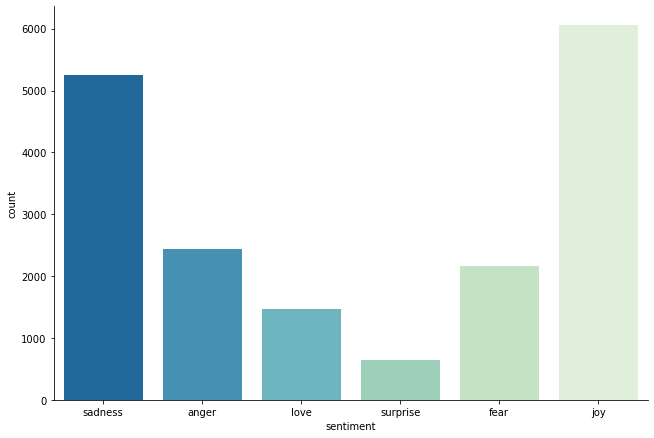

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.factorplot(x="sentiment", data=final_df, kind="count", size=6, aspect=1.5, palette="GnBu_r")
plt.show();

In [32]:
#Feature encoding
from sklearn.preprocessing import LabelEncoder
lbl_enc = LabelEncoder()

In [34]:
y = lbl_enc.fit_transform(final_df.sentiment.values) #Label encoding 

In [35]:
#For building a dataframe for mapping emotions to label number
y_series = pd.Series(y)
emo_cols_series = pd.Series(lbl_enc.inverse_transform(y))  #inverse transform to find  mapped emotions

In [36]:
emo_df = pd.DataFrame()
emo_df = pd.concat([emo_cols_series,y_series],axis=1)
emo_df.columns=['emotion','Label_mapped']

In [37]:
emo_df = emo_df.drop_duplicates()
emo_df.sort_values(by=['Label_mapped'],ascending= True)

,emotion,Label_mapped
2,anger,0
7,fear,1
8,joy,2
3,love,3
0,sadness,4
6,surprise,5


In [38]:
#Train test split 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X_train,X_val,y_train,y_val = train_test_split(final_df.text.values,final_df.sentiment.values,random_state=42, test_size=0.1, shuffle=True)

In [39]:
#Extracting Tf-idf features

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1)

In [40]:
#TF-idf approach
tfidf.fit(list(X_train) + list(X_val))
X_train_tfidf = tfidf.transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)
y_pred = nb.predict(X_val_tfidf)
print('naive bayes tfidf accuracy %s' % accuracy_score(y_pred, y_val))

naive bayes tfidf accuracy 0.7566666666666667


In [42]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_tfidf,y_train)
y_pred2 = rf.predict(X_val_tfidf)
print('Random forest tfidf accuracy %s' % accuracy_score(y_pred2, y_val))

Random forest tfidf accuracy 0.8788888888888889


In [43]:
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier(alpha=0.001, random_state=5, max_iter=15, tol=None)
lsvm.fit(X_train_tfidf, y_train)
y_pred_sgd = lsvm.predict(X_val_tfidf)
print('SGD using tfidf accuracy %s' % accuracy_score(y_pred_sgd, y_val))

SGD using tfidf accuracy 0.8816666666666667


In [44]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0)
lr.fit(X_train_tfidf,y_train)
y_pred = lr.predict(X_val_tfidf)
print('Accuracy with Logistic Regression and Tf-idf is {}'.format(accuracy_score(y_pred,y_val)))

Accuracy with Logistic Regression and Tf-idf is 0.8705555555555555


C:\Users\Manju Krishna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
#Count Vector approach
from sklearn.feature_extraction.text import CountVectorizer
count_vec = CountVectorizer(analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3))
count_vec.fit(list(X_train) + list(X_val))

CountVectorizer(ngram_range=(1, 3), token_pattern='\\w{1,}')

In [46]:
X_train_count_vec = count_vec.transform(X_train)
X_val_count_vec = count_vec.transform(X_val)

In [47]:
#Using Countvec for model

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_count_vec, y_train)
y_pred_nb = nb.predict(X_val_count_vec)
print('naive bayes count_vec accuracy %s' % accuracy_score(y_pred_nb, y_val))

naive bayes count_vec accuracy 0.7938888888888889


In [48]:
from sklearn.metrics import classification_report

In [49]:
print(classification_report(y_pred_nb,y_val))

              precision    recall  f1-score   support

       anger       0.65      0.90      0.75       180
        fear       0.62      0.83      0.71       145
         joy       0.95      0.78      0.86       710
        love       0.37      0.85      0.51        67
     sadness       0.97      0.76      0.85       691
    surprise       0.09      0.86      0.16         7

    accuracy                           0.79      1800
   macro avg       0.61      0.83      0.64      1800
weighted avg       0.87      0.79      0.82      1800



In [50]:
from sklearn.linear_model import SGDClassifier
lsvm = SGDClassifier()
lsvm.fit(X_train_count_vec, y_train)
y_pred_lsvm= lsvm.predict(X_val_count_vec)
print('svm using countvec accuracy %s' % accuracy_score(y_pred_lsvm, y_val))

svm using countvec accuracy 0.89


In [51]:
print(classification_report(y_pred_lsvm,y_val))

              precision    recall  f1-score   support

       anger       0.87      0.93      0.90       235
        fear       0.81      0.86      0.84       183
         joy       0.94      0.88      0.91       631
        love       0.75      0.82      0.79       142
     sadness       0.94      0.92      0.93       556
    surprise       0.67      0.83      0.74        53

    accuracy                           0.89      1800
   macro avg       0.83      0.87      0.85      1800
weighted avg       0.89      0.89      0.89      1800



In [52]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train_count_vec,y_train)
y_pred2_rf = rf.predict(X_val_count_vec)
print('Random forest tfidf accuracy %s' % accuracy_score(y_pred2_rf, y_val))

Random forest tfidf accuracy 0.8983333333333333


In [53]:
print(classification_report(y_pred2_rf,y_val))

              precision    recall  f1-score   support

       anger       0.91      0.92      0.91       247
        fear       0.80      0.89      0.85       175
         joy       0.95      0.88      0.91       634
        love       0.71      0.82      0.76       134
     sadness       0.95      0.94      0.95       554
    surprise       0.68      0.80      0.74        56

    accuracy                           0.90      1800
   macro avg       0.83      0.88      0.85      1800
weighted avg       0.90      0.90      0.90      1800



In [54]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0)
lr.fit(X_train_count_vec,y_train)
y_pred_lr = lr.predict(X_val_count_vec)
print('Accuracy with Logistic Regression and CountVec is {}'.format(accuracy_score(y_pred_lr,y_val)))

C:\Users\Manju Krishna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy with Logistic Regression and CountVec is 0.8888888888888888


In [55]:
print(classification_report(y_pred_lr,y_val))

              precision    recall  f1-score   support

       anger       0.87      0.93      0.90       233
        fear       0.82      0.84      0.83       190
         joy       0.94      0.88      0.91       623
        love       0.74      0.80      0.77       142
     sadness       0.95      0.92      0.93       564
    surprise       0.64      0.88      0.74        48

    accuracy                           0.89      1800
   macro avg       0.82      0.87      0.85      1800
weighted avg       0.89      0.89      0.89      1800



overall emotion prediction for a given text

In [56]:
text= pd.DataFrame(["For instance, giving a kiss to your younger sibling daily after waking up in the morning and showing him how much you love them. For some happiness means loving life and seeing others happy. While some finds happiness in writing stories. Some conquer happiness in being simple yet the best person they can ever be. Everyone has their own unique way to feel happy by finding things that they never expected to find.", # happy
        "Love is the key to happiness. We all want to lead a happy life. People look around for happiness in power, fashion, wealth, drugs etc. But these things can only give temporary pleasures. The power of love can create miracles. Love can create unity among nations and its citizens. Love is the most beautiful feeling in the world. Love has given different meaning by different people depending upon how they have experienced this wonderful feeling.", # love
        "One day I was studying in my room when, all of a sudden, i heard hot words being exchanged between two persons in the street. I paid no attention, thinking it would be a minor quarrel but soon I heard the voices of a large number of people. I peeped from the window and saw that there was a street quarrel. I went downstairs and reached the spot in the twinkling of an eyes. I was at my wits end on seeing that both of them had come to blows. The people were standing around them and enjoying their quarrel but none tried to pacify them.", # sad
        "I am so angry at you!!!!!", # anger
        "you ve hit a new low with a danger of blm fascist slogan please stop it before too late stop", # anger
        "I love my doggg", # love
        "I think i'm gonna be sick :'‑(", # sad
        "I hate you so much", # anger
        "I'm at work", # neutral
        "@TheTombert i was watching Harpers Island, lol... there was no vodka involved", # neutral
        "sometimes i wish things could go back to the way they were the beginning of last summer", # sad
        "it's your 18th birthday finally!!! yippeeeee", # happy
        "still waiting in line", # neutral
        "aarrgghh - fu*k.....a hose has leaked water all over the new floating floor", # anger
        "that b*tch is so ugly", # anger
        "oh no he is hospitalised!!!", # sad
       ])

text_count = count_vec.transform(text[0])

In [57]:
#Predicting the emotion of the tweet 
text_pred = lr.predict(text_count)
print(text_pred)
text[0]
# 0 = neutral
# 1 = happy
# 2 = sad
# 3 = love
# 4 = anger

['joy' 'joy' 'anger' 'anger' 'sadness' 'joy' 'anger' 'sadness' 'joy' 'joy'
 'joy' 'joy' 'joy' 'joy' 'sadness' 'joy']


0     For instance, giving a kiss to your younger si...
1     Love is the key to happiness. We all want to l...
2     One day I was studying in my room when, all of...
3                             I am so angry at you!!!!!
4     you ve hit a new low with a danger of blm fasc...
5                                       I love my doggg
6                        I think i'm gonna be sick :'‑(
7                                    I hate you so much
8                                           I'm at work
9     @TheTombert i was watching Harpers Island, lol...
10    sometimes i wish things could go back to the w...
11         it's your 18th birthday finally!!! yippeeeee
12                                still waiting in line
13    aarrgghh - fu*k.....a hose has leaked water al...
14                                that b*tch is so ugly
15                          oh no he is hospitalised!!!
Name: 0, dtype: object

In [58]:
final_result=text.copy()

In [59]:
final_result['result']=text_pred
final_result=final_result.rename(columns={0:"text"})
final_result=final_result.rename(columns={"result":"predicted_emotion"})
final_result=final_result.replace({0: 'Neutral', 1: 'Happy', 2: 'Sad', 3: 'Love', 4: 'Anger'})
final_result

,text,predicted_emotion
0,"For instance, giving a kiss to your younger si...",joy
1,Love is the key to happiness. We all want to l...,joy
2,"One day I was studying in my room when, all of...",anger
3,I am so angry at you!!!!!,anger
4,you ve hit a new low with a danger of blm fasc...,sadness
5,I love my doggg,joy
6,I think i'm gonna be sick :'‑(,anger
7,I hate you so much,sadness
8,I'm at work,joy
9,"@TheTombert i was watching Harpers Island, lol...",joy
